# **Installation of JDK,SPARK,HADOOP and PYSPARK**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.0.1-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark
!pip install pyspark

# **Dataset downloading and unzipping**

In [ ]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00526/data.zip

In [ ]:
from zipfile import ZipFile as zip

In [ ]:
zip('/content/data.zip').extractall()

# **Spark**

## **Spark Context Initialisation**

In [ ]:
from pyspark import SparkContext

In [ ]:
sc = SparkContext()

##**Loading the dataset to the spark SQL session**

In [ ]:
from pyspark.sql import DataFrameReader,SparkSession

In [ ]:
spark = SparkSession.builder.master("local[8]").appName('BitcoinHeist').getOrCreate()

In [ ]:
dataset = spark.read.options(header='True', infershema=True) \
  .csv("/content/BitcoinHeistData.csv")

In [ ]:
dataset.printSchema()

root
 |-- address: string (nullable = true)
 |-- year: string (nullable = true)
 |-- day: string (nullable = true)
 |-- length: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- count: string (nullable = true)
 |-- looped: string (nullable = true)
 |-- neighbors: string (nullable = true)
 |-- income: string (nullable = true)
 |-- label: string (nullable = true)



In [ ]:
dataset.show()

+--------------------+----+---+------+--------------------+-----+------+---------+---------+--------------------+
|             address|year|day|length|              weight|count|looped|neighbors|   income|               label|
+--------------------+----+---+------+--------------------+-----+------+---------+---------+--------------------+
|111K8kZAEnJg245r2...|2017| 11|    18| 0.00833333333333333|    1|     0|        2|100050000|     princetonCerber|
|1123pJv8jzeFQaCV4...|2016|132|    44|      0.000244140625|    1|     0|        1|    1e+08|      princetonLocky|
|112536im7hy6wtKbp...|2016|246|     0|                   1|    1|     0|        2|    2e+08|     princetonCerber|
|1126eDRw2wqSkWosj...|2016|322|    72|          0.00390625|    1|     0|        2| 71200000|     princetonCerber|
|1129TSjKtx65E35Gi...|2016|238|   144|  0.0728484071989931|  456|     0|        1|    2e+08|      princetonLocky|
|112AmFATxzhuSpvtz...|2016| 96|   144|  0.0846139993386755| 2821|     0|        1|    5e

## **Exploratory Data Analysis**

In [ ]:
float_features = ['year','day','length','weight','count','looped','neighbors','income']
for feature in float_features:
  dataset = dataset.withColumn(feature,dataset[feature].cast("float"))

In [ ]:
dataset.printSchema()

root
 |-- address: string (nullable = true)
 |-- year: float (nullable = true)
 |-- day: float (nullable = true)
 |-- length: float (nullable = true)
 |-- weight: float (nullable = true)
 |-- count: float (nullable = true)
 |-- looped: float (nullable = true)
 |-- neighbors: float (nullable = true)
 |-- income: float (nullable = true)
 |-- label: string (nullable = true)



In [ ]:
dataset.count()

2916697

In [ ]:
dataset.describe(dataset.columns).show()

+-------+--------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+--------------------+-----------+
|summary|             address|             year|               day|           length|            weight|            count|            looped|         neighbors|              income|      label|
+-------+--------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+--------------------+-----------+
|  count|             2916697|          2916697|           2916697|          2916697|           2916697|          2916697|           2916697|           2916697|             2916697|    2916697|
|   mean|                null|2014.475011288454|  181.457211016434|45.00859293920486|0.5455192342715912|721.6446428957139|238.50669884461772| 2.206516137946451| 4.464889005939135E9|       null|
| stddev|                null|

In [ ]:
from pyspark.sql.functions import col,count,isnan,when

In [ ]:
dataset.select([count(when(isnan(c),c)).alias(c) for c in dataset.columns]).show()

+-------+----+---+------+------+-----+------+---------+------+-----+
|address|year|day|length|weight|count|looped|neighbors|income|label|
+-------+----+---+------+------+-----+------+---------+------+-----+
|      0|   0|  0|     0|     0|    0|     0|        0|     0|    0|
+-------+----+---+------+------+-----+------+---------+------+-----+



In [ ]:
corr_features = dataset.columns[1:-1]
total_corr=[]
for feature1 in corr_features:
  feature_corr=[]
  for feature2 in corr_features[corr_features.index(feature1):]:
    print("{} : {}".format(corr_features.index(feature1),corr_features.index(feature2)))
    feature_corr.append(dataset.corr(feature1,feature2))
  total_corr.append(feature_corr)

0 : 0
0 : 1
0 : 2
0 : 3
0 : 4
0 : 5
0 : 6
0 : 7
1 : 1
1 : 2
1 : 3
1 : 4
1 : 5
1 : 6
1 : 7
2 : 2
2 : 3
2 : 4
2 : 5
2 : 6
2 : 7
3 : 3
3 : 4
3 : 5
3 : 6
3 : 7
4 : 4
4 : 5
4 : 6
4 : 7
5 : 5
5 : 6
5 : 7
6 : 6
6 : 7
7 : 7


In [ ]:
for feature_corr in range(len(total_corr)):
  print("{} : {}".format(dataset.columns[feature_corr],total_corr[feature_corr]))

address : [1.0, -0.040306603430984383, 0.1631011109906387, 0.011827127867104327, 0.28541539897245655, 0.11316432037537676, -0.000876275101302997, -0.0205345128802686]
year : [1.0, 0.011919285649091685, 0.0008639762412572149, -0.0025377845987540823, 0.002565624366969112, 0.00018112259699026165, 0.0026275680241238048]
day : [1.0, 0.00022836115982720223, 0.7034670508329549, 0.4116092274572861, 0.031523089139835654, 0.0004882058210412541]
length : [1.0, 0.022312511934134957, 0.06164630525048874, 0.6919625578996685, 0.06977410384581713]
weight : [1.0, 0.5603700276351703, 0.02544092727203195, -0.0036346768396950265]
count : [1.0, 0.05282569935227837, 0.0025505823050875538]
looped : [1.0, 0.13896603309383787]
neighbors : [1.0]


In [ ]:
feature_data = dataset.rdd.map(lambda row : row[0:])

In [ ]:
data_sample = feature_data.take(1000)

In [ ]:
from pyspark.ml.feature import StringIndexer

In [ ]:
label = dataset.select('label')

In [ ]:
encoder = StringIndexer(inputCol='label',outputCol='y').fit(label)

In [ ]:
encoder.transform(label).show()

+--------------------+---+
|               label|  y|
+--------------------+---+
|     princetonCerber|3.0|
|      princetonLocky|4.0|
|     princetonCerber|3.0|
|     princetonCerber|3.0|
|      princetonLocky|4.0|
|      princetonLocky|4.0|
|     princetonCerber|3.0|
|     princetonCerber|3.0|
|     princetonCerber|3.0|
|      princetonLocky|4.0|
|montrealCryptoLocker|2.0|
|     princetonCerber|3.0|
|    montrealCryptXXX|5.0|
|     princetonCerber|3.0|
|    montrealCryptXXX|5.0|
|    montrealCryptXXX|5.0|
|      princetonLocky|4.0|
|      princetonLocky|4.0|
|     princetonCerber|3.0|
|      princetonLocky|4.0|
+--------------------+---+
only showing top 20 rows



In [ ]:
features = dataset.drop('address')

In [ ]:
features = features.drop('label') 
features.show()

+------+-----+------+------------+------+------+---------+--------+
|  year|  day|length|      weight| count|looped|neighbors|  income|
+------+-----+------+------------+------+------+---------+--------+
|2017.0| 11.0|  18.0| 0.008333334|   1.0|   0.0|      2.0|1.0005E8|
|2016.0|132.0|  44.0|2.4414062E-4|   1.0|   0.0|      1.0|   1.0E8|
|2016.0|246.0|   0.0|         1.0|   1.0|   0.0|      2.0|   2.0E8|
|2016.0|322.0|  72.0|  0.00390625|   1.0|   0.0|      2.0|  7.12E7|
|2016.0|238.0| 144.0|  0.07284841| 456.0|   0.0|      1.0|   2.0E8|
|2016.0| 96.0| 144.0|    0.084614|2821.0|   0.0|      1.0|   5.0E7|
|2016.0|225.0| 142.0|0.0020885186| 881.0|   0.0|      2.0|   1.0E8|
|2016.0|324.0|  78.0|  0.00390625|   1.0|   0.0|      2.0|1.0099E8|
|2016.0|298.0| 144.0|   2.3028283|4220.0|   0.0|      2.0|   8.0E7|
|2016.0| 62.0| 112.0|3.7252903E-9|   1.0|   0.0|      1.0|   5.0E7|
|2013.0|317.0|   4.0| 0.007142857|   2.0|   0.0|      1.0|   1.0E8|
|2016.0|247.0|   0.0|         1.0|   1.0|   0.0|

In [ ]:
from pyspark.mllib.feature import StandardScaler

In [ ]:
col_names = features.columns
features_rdd = features.rdd.map(lambda row: row[0:])
scaler = StandardScaler(True,True).fit(features_rdd)
scaled_features=scaler.transform(features_rdd)

In [ ]:
print(scaled_features.take(10))

[DenseVector([1.1185, -1.6388, -0.4579, -0.1462, -0.4265, -0.2468, -0.0115, -0.0268]), DenseVector([0.6756, -0.4755, -0.0171, -0.1484, -0.4265, -0.2468, -0.0673, -0.0268]), DenseVector([0.6756, 0.6205, -0.7631, 0.1237, -0.4265, -0.2468, -0.0115, -0.0262]), DenseVector([0.6756, 1.3512, 0.4576, -0.1474, -0.4265, -0.2468, -0.0115, -0.027]), DenseVector([0.6756, 0.5436, 1.6783, -0.1286, -0.1572, -0.2468, -0.0673, -0.0262]), DenseVector([0.6756, -0.8216, 1.6783, -0.1254, 1.2425, -0.2468, -0.0673, -0.0271]), DenseVector([0.6756, 0.4186, 1.6444, -0.1479, 0.0943, -0.2468, -0.0115, -0.0268]), DenseVector([0.6756, 1.3704, 0.5593, -0.1474, -0.4265, -0.2468, -0.0115, -0.0268]), DenseVector([0.6756, 1.1205, 1.6783, 0.4783, 2.0704, -0.2468, -0.0115, -0.027]), DenseVector([0.6756, -1.1485, 1.1358, -0.1485, -0.4265, -0.2468, -0.0673, -0.0271])]


In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
 
feat_cols = ['year','day', 'length',
'weight', 'count','looped','neighbors','income']
 
vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features_unscaled')
 
final_data = vec_assembler.transform(features)
final_data.show()

+------+-----+------+------------+------+------+---------+--------+--------------------+
|  year|  day|length|      weight| count|looped|neighbors|  income|   features_unscaled|
+------+-----+------+------------+------+------+---------+--------+--------------------+
|2017.0| 11.0|  18.0| 0.008333334|   1.0|   0.0|      2.0|1.0005E8|[2017.0,11.0,18.0...|
|2016.0|132.0|  44.0|2.4414062E-4|   1.0|   0.0|      1.0|   1.0E8|[2016.0,132.0,44....|
|2016.0|246.0|   0.0|         1.0|   1.0|   0.0|      2.0|   2.0E8|[2016.0,246.0,0.0...|
|2016.0|322.0|  72.0|  0.00390625|   1.0|   0.0|      2.0|  7.12E7|[2016.0,322.0,72....|
|2016.0|238.0| 144.0|  0.07284841| 456.0|   0.0|      1.0|   2.0E8|[2016.0,238.0,144...|
|2016.0| 96.0| 144.0|    0.084614|2821.0|   0.0|      1.0|   5.0E7|[2016.0,96.0,144....|
|2016.0|225.0| 142.0|0.0020885186| 881.0|   0.0|      2.0|   1.0E8|[2016.0,225.0,142...|
|2016.0|324.0|  78.0|  0.00390625|   1.0|   0.0|      2.0|1.0099E8|[2016.0,324.0,78....|
|2016.0|298.0| 144.0|

In [ ]:
from pyspark.ml.stat import Correlation

# Get correlation DataFrame, collect and extract a pyspark.mllib.linalg.DenseMatrix, convert to array 
corr_mat = Correlation.corr(final_data, 'features_unscaled').collect()[0][0].toArray()

In [ ]:
import pandas as pd
corr_mat = pd.DataFrame(corr_mat, index=feat_cols, columns=feat_cols)
corr_mat.head(len(feat_cols))


,year,day,length,weight,count,looped,neighbors,income
year,1.000000,-0.040307,0.163101,0.011827,0.285415,0.113164,-0.000876,-0.020535
day,-0.040307,1.000000,0.011919,0.000864,-0.002538,0.002566,0.000181,0.002628
length,0.163101,0.011919,1.000000,0.000228,0.703467,0.411609,0.031523,0.000488
weight,0.011827,0.000864,0.000228,1.000000,0.022313,0.061646,0.691963,0.069774
count,0.285415,-0.002538,0.703467,0.022313,1.000000,0.560370,0.025441,-0.003635
looped,0.113164,0.002566,0.411609,0.061646,0.560370,1.000000,0.052826,0.002551
neighbors,-0.000876,0.000181,0.031523,0.691963,0.025441,0.052826,1.000000,0.138966
income,-0.020535,0.002628,0.000488,0.069774,-0.003635,0.002551,0.138966,1.000000


In [ ]:
from itertools import cycle, islice
from math import sqrt
from numpy import array
#from pandas.tools.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

In [ ]:
def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)

In [ ]:
def elbow(elbowset, clusters):
    wsseList = []	
    for k in clusters:
        print("Training for cluster size {} ".format(k))
        kmeans = KMeans(k = k, seed = 1)
        model = kmeans.fit(elbowset)
        transformed = model.transform(elbowset)
        featuresAndPrediction = transformed.select("features", "prediction")

        W = computeCost(featuresAndPrediction, model)
        print("......................WSSE = {} ".format(W))

        wsseList.append(W)
    return wsseList

def elbow_plot(wsseList, clusters):
    wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
    wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

In [ ]:
!pip install utils

In [ ]:
train_df, test_df = final_data.randomSplit([0.75, 0.25], seed=12345)
train_df.count(), test_df.count()


(2187030, 729667)

In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(train_df)

train_df = scalerModel.transform(train_df)
test_df = scalerModel.transform(test_df)


Trying k from 3 to 29 with 1094418 samples...

Training for cluster size 3 
......................WSSE = 1829930.4835065021 
Training for cluster size 4 
......................WSSE = 1402814.7598745856 
Training for cluster size 5 
......................WSSE = 1399779.7216525697 
Training for cluster size 6 
......................WSSE = 1459274.4009020287 
Training for cluster size 7 
......................WSSE = 1373014.1788052516 
Training for cluster size 8 
......................WSSE = 1194559.139400288 
Training for cluster size 9 
......................WSSE = 1149876.6859336945 
Training for cluster size 10 
......................WSSE = 1275329.0713250812 
Training for cluster size 11 
......................WSSE = 1075855.9158061347 
Training for cluster size 12 
......................WSSE = 1078958.265511252 
Training for cluster size 13 
......................WSSE = 1074341.5807136851 
Training for cluster size 14 
......................WSSE = 1124693.0744623824 
Training for c

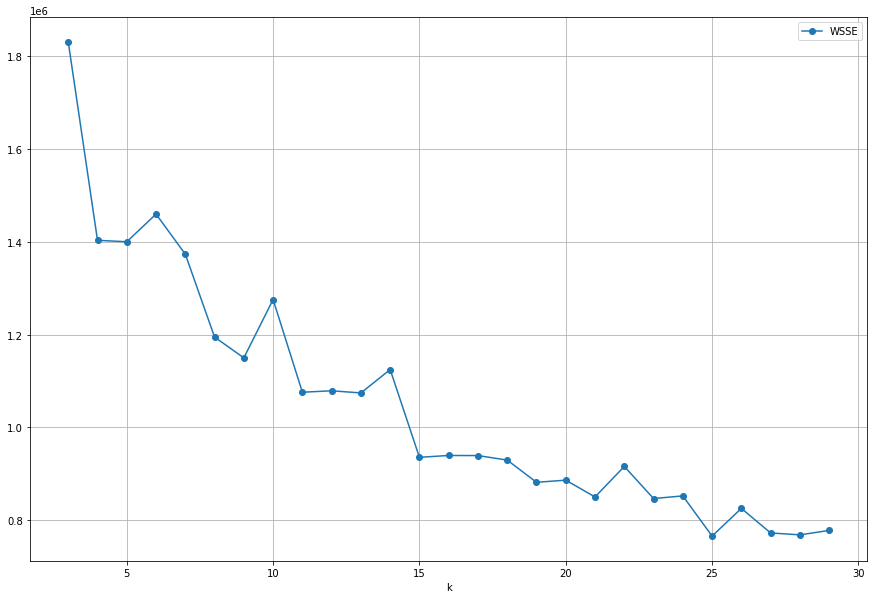

In [ ]:
create_elbow_plot = True # Set to False if already know value for k

if create_elbow_plot == True:
    # lower the sample fraction to decrease fit time (with the risk of worse results)
    sampled = train_df.sample(.5)

    k_attempts = range(3,30)
    print('Trying k from {} to {} with {} samples...\n'.format(list(k_attempts)[0],
                                                               list(k_attempts)[-1],
                                                               sampled.count()))

    wsseList = elbow(sampled, k_attempts)
    elbow_plot(wsseList, k_attempts)

#cost = np.zeros(20)
#for k in range(2,20):
    #kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    #model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    #cost[k] = model.computeCost(df_kmeans)

#fig, ax = plt.subplots(1,1, figsize =(8,6))
#ax.plot(range(2,20),cost[2:20])
#ax.set_xlabel('k')

#ax.set_ylabel('cost')

In [ ]:
import time
from pyspark.ml.clustering import KMeans
st=time.time()
kmeans = KMeans(k=10)
model = kmeans.fit(train_df)
print("Time Taken to fit the model:"+ str(time.time()-st))

Time Taken to fit the model:136.95307993888855


In [ ]:
from pyspark.ml.clustering import KMeans

K = 10
kmeans = KMeans(k=K)
model = kmeans.fit(train_df)
centers = model.clusterCenters()


print("Cluster Centers: ")
for center in centers:
    print("\n")
    print(center)

Cluster Centers: 


[-1.09059142  0.05191727 -0.53099488 -0.02374296 -0.42164539 -0.24586448
 -0.02518789  0.01279792]


[ 0.11135005  0.04384265  1.67302089  0.02402257  1.2543845   2.3343419
  0.08739254 -0.01321232]


[1.56204842e+00 2.16734998e-01 1.67814939e+00 4.89152839e+02
 2.41813724e+00 4.72285740e+00 5.59311116e+02 3.79359246e+01]


[ 0.62803633 -0.9747406  -0.5821587   0.00632885 -0.42545475 -0.24649773
 -0.01743181 -0.01506865]


[ 1.16819010e+00 -1.19786992e-01  8.86985841e-01  2.33097902e+02
  2.79516012e+00  5.37989405e+00  5.74316765e+01  3.99627075e+00]


[-0.00360111  0.02475882  1.59231134 -0.05174862  0.31040499 -0.06491851
 -0.00240366 -0.00522092]


[ 9.79392351e-01  3.47882529e-02  1.67131830e+00  2.54649116e-01
  3.61181755e+00  6.25688627e+00  1.19235706e-01 -1.89165234e-03]


[ 1.10279234 -0.02421957  1.65230827 -0.04810357  2.78669526 -0.21646404
 -0.02028593 -0.01881686]


[ 0.72019695  0.8859254  -0.58286003  0.00990222 -0.42566059 -0.24657291
 -0.01639159

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
predictions = model.transform(train_df)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.45835131732693407


In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
cost = list()
evaluator = ClusteringEvaluator()
for k in range(2,15):
    bkm = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    bkm_model = bkm.fit(train_df)
    tags_predictions = bkm_model.transform(train_df)
    silhouette = evaluator.evaluate(predictions)
    cost.append(silhouette)
    
kIdx = np.argmax(cost)

fig, ax = plt.subplots()
plt.plot(range(2,15), cost, 'b*-')
plt.plot(range(2,15)[kIdx], cost[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Scores for k-means clustering')
display(fig)

In [ ]:
silhouette_coefficients = []
for k in range(2, 11):
  #evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)
silhouette_coefficients.append(silhouette)
plt.plot(range(2, 11), silhouette_coefficients, 'bx-')
plt.xlabel("No of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
transformed = model.transform(train_df).select('year','day', 'length','weight', 'count','looped','neighbors','income', 'prediction')
#transformed = model.transform(test_df).select('year', 'prediction')
rows = transformed.collect()
print(rows[:2])

[Row(year=2011.0, day=1.0, length=0.0, weight=0.5, count=1.0, looped=0.0, neighbors=1.0, income=43000000.0, prediction=0), Row(year=2011.0, day=1.0, length=0.0, weight=0.5, count=1.0, looped=0.0, neighbors=1.0, income=43000000.0, prediction=0)]


In [ ]:
from pyspark.sql import SQLContext
df_pred = spark.createDataFrame(rows)
df_pred.show()

+------+---+------+------+-----+------+---------+-------------+----------+
|  year|day|length|weight|count|looped|neighbors|       income|prediction|
+------+---+------+------+-----+------+---------+-------------+----------+
|2011.0|1.0|   0.0|   0.5|  1.0|   0.0|      1.0|        4.3E7|         0|
|2011.0|1.0|   0.0|   0.5|  1.0|   0.0|      1.0|        4.3E7|         0|
|2011.0|1.0|   0.0|   0.5|  1.0|   0.0|      1.0|        4.6E7|         0|
|2011.0|1.0|   0.0|   0.5|  1.0|   0.0|      1.0|        9.0E7|         0|
|2011.0|1.0|   0.0|   0.5|  1.0|   0.0|      1.0|        1.0E8|         0|
|2011.0|1.0|   0.0|   0.5|  1.0|   0.0|      1.0|        1.0E8|         0|
|2011.0|1.0|   0.0|   0.5|  1.0|   0.0|      1.0|       1.01E8|         0|
|2011.0|1.0|   0.0|   0.5|  1.0|   0.0|      1.0|       1.26E8|         0|
|2011.0|1.0|   0.0|   0.5|  1.0|   0.0|      1.0|        2.0E8|         0|
|2011.0|1.0|   0.0|   0.5|  1.0|   0.0|      1.0|        4.1E8|         0|
|2011.0|1.0|   0.0|   0.5

In [ ]:
pddf_pred = df_pred.toPandas()
pddf_pred.head(10)

,year,day,length,weight,count,looped,neighbors,income,prediction
0,2011.0,1.0,0.0,0.5,1.0,0.0,1.0,43000000.0,0
1,2011.0,1.0,0.0,0.5,1.0,0.0,1.0,43000000.0,0
2,2011.0,1.0,0.0,0.5,1.0,0.0,1.0,46000000.0,0
3,2011.0,1.0,0.0,0.5,1.0,0.0,1.0,90000000.0,0
4,2011.0,1.0,0.0,0.5,1.0,0.0,1.0,100000000.0,0
5,2011.0,1.0,0.0,0.5,1.0,0.0,1.0,100000000.0,0
6,2011.0,1.0,0.0,0.5,1.0,0.0,1.0,101000000.0,0
7,2011.0,1.0,0.0,0.5,1.0,0.0,1.0,126000000.0,0
8,2011.0,1.0,0.0,0.5,1.0,0.0,1.0,200000000.0,0
9,2011.0,1.0,0.0,0.5,1.0,0.0,1.0,410000000.0,0


In [ ]:
pddf_pred['prediction'].value_counts()

2    455796
0    450994
1    438507
5    263362
9    259864
6    254684
4     63023
8       769
3        28
7         3
Name: prediction, dtype: int64

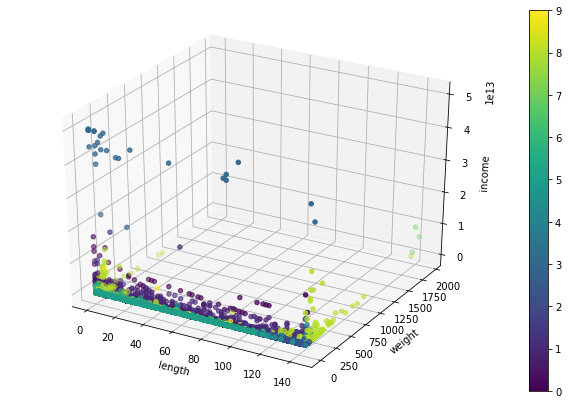

In [ ]:
#silhouette_coefficients = []
fig = plt.figure(figsize=(11,7))
ax = plt.axes(projection='3d')
sctt = ax.scatter3D(pddf_pred['length'], pddf_pred['weight'], pddf_pred['income'], c=pddf_pred.prediction,cmap="viridis")
ax.set_xlabel('length')
ax.set_ylabel('weight')
ax.set_zlabel('income')
fig.colorbar(sctt, ax=ax)
plt.show()

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred['length'], pddf_pred['weight'], pddf_pred['income'], c=pddf_pred.prediction,cmap="viridis")
threedee.set_xlabel('length')
threedee.set_ylabel('weight')
threedee.set_zlabel('income')
plt.colorbar()
plt.show()

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred['length'], pddf_pred['weight'], pddf_pred['income'], c=model.prediction)
threedee.set_xlabel('length')
threedee.set_ylabel('weight')
threedee.set_zlabel('income')
plt.show()